**Importing necessary libraries for data visualization and manipulation :**

In [1]:
# Importing necessary libraries for data visualization and manipulation

# Used for creating static, interactive, and animated visualizations in Python
import matplotlib.pyplot as plt

# Used for creating line markers within plots
from matplotlib.lines import Line2D

# Provides a way of using operating system dependent functionality like reading or writing to a file system
import os

# Implements binary protocols for serializing and de-serializing a Python object structure.
import pickle

# Data manipulation and analysis library
import pandas as pd

# Fundamental package for scientific computing with Python
import numpy as np

# Represents a duration, the difference between two dates or times.
from datetime import timedelta

from scipy import interpolate  # Subpackage for interpolation which provides functions to deal with interpolation algorithms.
from scipy import signal
from scipy.stats import pearsonr

**Import ppg data with Nans**

In [2]:
# Define the directory containing the patient files
directory = 'C:/Users/adior/Documents/Digital Medical Tech - degree/Final Mop Project/Train Files/Train files with Nan'
#directory = 'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/Train Files with NaN'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Initialize an empty dictionary to store DataFrames
wind_dict = {}

# Load each CSV file into a DataFrame and store it in the dictionary
for i, file in enumerate(csv_files):
    file_path = os.path.join(directory, file)
    try:
        df = pd.read_csv(file_path)
        wind_dict[i] = df
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")

The goal here is to filter out and retain only those segments that are continuous and have a duration of at least 12 seconds.

The data is filtered by first removing any rows where the 'PLETH' values are Nans.
The filtered data is then checked for gaps in the timestamp values,if a gap larger than 10 milliseconds is found, the segment is split at that point.
Each segment is then checked to ensure it contains at least 1200 rows (since the sampling frequency is 100 Hz, 1200 rows would correspond to 12 seconds).

Only the segments that are continuous and at least 12 seconds long are kept, and these are stored in a new dictionary called valid_segments_dict

**Filtering Non-NaN Segments that last at least 12-second**

In [3]:
# Initialize an empty dictionary to store valid segments of PPG data
valid_segments_dict = {}
# Initialize an index to keep track of the segment number
segment_index = 0

# Iterate through each DataFrame in wind_dict
for file, df in wind_dict.items():
    # Filter the DataFrame to retain only rows where 'PLETH' values are not NaN
    notna_fd = df[df['PLETH'].notna()]

    # Extract the timestamp values from the filtered DataFrame
    time_stamps = notna_fd['TIMESTAMP_MS'].values
    # Initialize the starting index for the current segment
    start_idx = 0
    
    # Loop through the timestamps to find gaps larger than 10 milliseconds
    for i in range(1, len(time_stamps)):
        gap_size = time_stamps[i] - time_stamps[i-1]
        # If a gap larger than 10 milliseconds is found
        if gap_size > 10:
            # Check if the segment length is at least 1200-second
            if len(notna_fd.iloc[start_idx:i]) >= 1200:
                # If valid, add the segment to valid_segments_dict
                valid_segments_dict[segment_index] = notna_fd.iloc[start_idx:i]
                # Increment the segment index for the next segment
                segment_index += 1
            # Update the start index to the current position after the gap
            start_idx = i

    # After the loop, check the last segment for validity (length >= 1200)
    if len(notna_fd.iloc[start_idx:]) >= 1200:
        # Add the last segment if valid
        valid_segments_dict[segment_index] = notna_fd.iloc[start_idx:]
        segment_index += 1

# Print the number of valid segments that have been identified and stored
print(f"Number of valid segments: {len(valid_segments_dict)}")


Number of valid segments: 636


# Pre-processing
Pre-processing of PPG signal segments includes smoothing the signal, finding cycles using the peak points in each cycle, two-dimensional normalization of PPG signals. Also, rejecting low-quality segments and cutting the segments so that they contain complete waves.

In [29]:
def FindProperWindows(PPG, Windows_Table, key, start_window_id, proper_windows):
    """
    Identifies and processes proper windows from the PPG data.

    Parameters:
    - PPG (DataFrame): The PPG signal data.
    - Windows_Table (DataFrame): The table to store window information and results.
    - key (int): The key identifying the current PPG segment.
    - start_window_id (int): The starting window_id for this segment.
    - proper_windows (dict): Dictionary to store the proper windows identified.

    Returns:
    - DataFrame: The updated Windows_Table with proper window information.
    - int: The updated window_id to continue from for the next segment.
    """
    window_size = 12 * 100  # 12 seconds window with fs=100
    start_idx = 0
    window_id = start_window_id
    windows_list = []

    while start_idx + window_size <= len(PPG):
        wind = GetWindow(PPG, start_idx, window_id, key)
        wind = WindowFullProcess(wind, by_value=True)

        # Append information to list
        window_info = {
            'window_id': window_id,
            'segment_index': key,
            'start_index': start_idx,
            'end_index': start_idx + window_size,
            'ProperWindow': False  # Default value, will be updated later
        }
        windows_list.append(window_info)

        Rejecting_Window(wind, windows_list[-1], window_id)

        if windows_list[-1]['ProperWindow']:
            wind['window_index'] = window_id
            proper_windows[window_id] = wind  # Store the proper window directly in the dictionary
            start_idx += 7 * 100  # move 7 seconds forward
        else:
            min_peaks, _ = Get_Cycles_Peaks(wind)
            if len(min_peaks) > 0:
                if start_idx == min_peaks[0]:
                    start_idx = min_peaks[1]
                else:
                    start_idx = min_peaks[0]
            else:
                start_idx += window_size

        # Increment the window_id for the next iteration
        window_id += 1

    # Convert list to DataFrame and concatenate
    new_windows = pd.DataFrame(windows_list)
    Windows_Table = pd.concat([Windows_Table, new_windows], ignore_index=True)

    Windows_Table['ProperWindow'] = Windows_Table['ProperWindow'].astype(bool)
    return Windows_Table, window_id


In [30]:
def Reset_Column(Table, col_name, col_ind, default):
    """
    Resets a column in the DataFrame to a specified default value.

    Parameters:
    - Table (DataFrame): The DataFrame to update.
    - col_name (str): The name of the column to reset.
    - col_ind (int): The index position to insert the column if it does not exist.
    - default: The default value to set for the column.

    """
    if col_name not in Table.columns:
        Table.insert(col_ind, col_name, default)
    else:
        Table[col_name] = default

In [31]:
def GetWindow(PPG, start_idx, window_id, segment_index, window_size=12*100):  # Assuming fs=100
    """
    Extracts a window of data from the PPG signal.

    Parameters:
    - PPG (DataFrame): The PPG signal data.
    - start_idx (int): The starting index for the window.
    - window_size (int): The size of the window (default is 1200, for 12 seconds at 100 Hz).

    Returns:
    - DataFrame: The extracted window of PPG data.
    """
    end_idx = start_idx + window_size
    return PPG.iloc[start_idx:end_idx]

**Each 12-second window undergoes several signal processing steps to clean and refine the data:**

Noise Filtering: A low-pass filter is applied to remove high-frequency noise.

Trend Removal: A high-pass filter is used to remove trends from the signal, leaving behind the oscillatory components that represent the heartbeats.

Auto-correlation: This measures the similarity of the signal to itself over time, helping identify regular patterns or cycles within the window.

Peak Detection: The function detects peaks (maxima and minima) in the signal that correspond to heartbeats. It uses methods like SDET (Successive Decomposition and Extraction of Peaks) for accurate detection.

In [32]:
def WindowFullProcess(wind, by_value=False, wind_id=None, fs=100, padding=250):
    """
    Processes a window of PPG data by applying various filters and transformations.

    Parameters:
    - wind (DataFrame): The window of PPG data to process.
    - by_value (bool): If True, processes a copy of the input data (default is False).
    - wind_id (optional): Identifier for the window.
    - fs (int): Sampling frequency (default is 100).
    - padding (int): Padding value for auto-correlation (default is 250).

    Returns:
    - DataFrame: The processed window of PPG data.
    """
    if by_value:
        wind = wind.copy()

    PLETH = wind['PLETH']

    # Initialize DataTime if not present
    if 'DataTime' not in wind.columns:
        wind['DataTime'] = np.arange(len(wind)) / fs

    # Apply butter - lowpass filter:
    filtered = Segment_Filter(PLETH, ftype='low', fs=fs)
    wind['F_PLETH'] = filtered

    # Removes the trend (Highpass filter) from the PPG signal:
    high_detrended = Segment_Trend_Removel(filtered, ftype='high', fs=fs)
    wind['HiDeTr_PLETH'] = high_detrended

    # Computes the auto-correlation of the PPG signal without normalization:
    auto_correlation = Segment_AutoCorrelation(high_detrended, normalized=False, padding=int(1*fs)) # 1*fs=1[sec]
    wind['AuCo_PLETH'] = auto_correlation

    # Computes the auto-correlation of the PPG signal with normalization:
    auto_correlation = Segment_AutoCorrelation(high_detrended, normalized=True, padding=int(1*fs)) # 1*fs=1[sec]
    wind['NoAuCo_PLETH'] = auto_correlation

    # Detects min and max peaks in the PPG signal.
    get_peaks(wind, y_name='HiDeTr_PLETH', is_window=True, method='SDET', padding=int(0.5*fs)) # 0.5*fs=2[sec]

    # Tests if the window contains consistent extremum points (maxima and minima).
    max_min_test(wind, to_raise=True)

    if by_value:
        return wind

In [33]:
def Segment_Filter(y, ftype='low', fs=100):
    """
    Applies a filter to the PPG signal.

    Parameters:
    - y (Series): The PPG signal to filter.
    - ftype (str): The type of filter to apply ('low' for lowpass, 'SG' for Savitzky-Golay).
    - fs (int): Sampling frequency (default is 100).

    Returns:
    - ndarray: The filtered PPG signal.
    """
    if ftype == 'SG':
        filtered = signal.savgol_filter(y, window_length=19, polyorder=4)
    elif ftype == 'low':
        b, a = signal.butter(5, 10, 'lowpass', fs=fs)
        filtered = signal.filtfilt(b, a, y)
    return filtered

In [34]:
def Segment_Trend_Removel(y, ftype='linar', fs=100):
    """
    Removes the trend from the PPG signal.

    Parameters:
    - y (Series): The PPG signal to detrend.
    - ftype (str): The type of detrending to apply ('linar' for linear, 'high' for highpass).
    - fs (int): Sampling frequency (default is 100).

    Returns:
    - ndarray: The detrended PPG signal.
    """
    if ftype == 'linar':
        detrended = signal.detrend(y)
    elif ftype == 'high':
        b, a = signal.butter(5, 0.6, 'highpass', fs=fs)
        detrended = signal.filtfilt(b, a, y)
    return detrended

In [35]:
def Segment_AutoCorrelation(y, normalized=False, padding=2.5*100):
    """
    Computes the auto-correlation of the PPG signal.

    Parameters:
    - y (Series): The PPG signal to auto-correlate.
    - normalized (bool): If True, normalizes the auto-correlation (default is False).
    - padding (int): Padding value for auto-correlation (default is 250).

    Returns:
    - Series: The auto-correlated PPG signal with padding.
    """
    cuted_y = y[int(padding//2):-int(padding//2)]

    corr = signal.correlate(cuted_y, cuted_y, mode='same')
    if normalized:
        a = np.arange(1, corr.size + 1)
        f = 1 - corr.size % 2
        b = np.concatenate([a, a[-2::-1]])[corr.size // 2 - f:-corr.size // 2]
        corr /= b
    corr /= corr.max()
    paded_corr = y.copy()
    paded_corr[:int(padding//2)] = np.nan
    paded_corr[-int(padding//2):] = np.nan
    paded_corr[int(padding//2):-int(padding//2)] = corr
    return paded_corr

In [37]:
def Patient_max_peaks(patient_PPG, y_name='HiDeTr_PLETH', is_window = False, padding=250, method='SDET'):
    """
    Detects maximum peaks in the PPG signal.

    Parameters:
    - patient_PPG (DataFrame): The PPG data.
    - y_name (str): The name of the column containing the PPG signal.
    - is_window (bool): If True, processes the data as a window.
    - padding (int): Padding value for peak detection (default is 250).
    - method (str): The method for peak detection ('SDET' or 'hp').

    """
    if 'is_max_peak' not in patient_PPG.columns:
        col_ind = int(np.argmax(patient_PPG.columns == y_name))
        patient_PPG.insert(col_ind, 'is_max_peak', False)
    else:
        patient_PPG['is_max_peak'] = False

    if is_window:
        continuous_groups = [list(patient_PPG.index)]
    else:
        print('Didnt get proper window')

    for i, index in enumerate(continuous_groups):

        y = patient_PPG.loc[index, y_name]

        max_peaks = Segment_max_peaks(y, method=method)
        if len(max_peaks):
            patient_PPG.loc[max_peaks, 'is_max_peak'] = True

In [38]:
def Segment_max_peaks(y, fs=100, method='SDET'):
    """
    Detects maximum peaks in a segment of the PPG signal.

    Parameters:
    - y (Series): The PPG signal.
    - fs (int): Sampling frequency (default is 100).
    - method (str): The method for peak detection ('SDET' or 'hp').

    Returns:
    - ndarray: Indices of the maximum peaks.
    """
    if method == 'hp':
        try:
            warnings.filterwarnings("ignore")
            working_data, _ = hp.process(y.values, fs)
            warnings.filterwarnings("default")
        except:
            max_peaks = np.array([])
        else:
            # Extract the 'peaklist' from the 'working_data' dictionary.
            max_peaks = np.array(working_data['peaklist'])
            max_peaks = y.index[max_peaks]
    elif method == 'SDET':
        maximum_heart_beat_frequency = 1.5 # [Hz]1.5 is lower the 1.67 Hz which is 100 bit per min which is the maximum hart bit
        maximum_signal_frequency = 10 #[Hz]
        steps = 10 - 1
        lowpass_fre_arr = np.linspace(maximum_heart_beat_frequency, maximum_signal_frequency, steps, endpoint=False)
        half_wind_size = int(1/(100/60)/4*fs) #[(1/(bit/min))/4*fs] = [(1/max_frec)/4*fs]
        peaks_indexes = SDET(y.values, lowpass_fre_arr, half_wind_size, fs=fs)
        if len(peaks_indexes):
            max_peaks = y.index[peaks_indexes]
        else:
            max_peaks = np.array([])

    return max_peaks

In [39]:
def SDET(y, lowpass_fre_arr, half_wind_size, fs=100, visual=False):
    """
    Applies the Successive Decomposition and Extraction of Peaks (SDET) method to identify peaks in the PPG signal.

    Parameters:
    - y (ndarray): The PPG signal to process.
    - lowpass_fre_arr (ndarray): Array of lowpass filter frequencies for successive filtering.
    - half_wind_size (int): Half the size of the window used for local peak detection.
    - fs (int): Sampling frequency (default is 100).
    - visual (bool): If True, visualizes the filtering and peak detection steps (default is False).

    Returns:
    - ndarray: The indices of the identified peaks in the PPG signal.
    """
    filtered_arr = []
    for lowpass_fre in lowpass_fre_arr:
        b, a = signal.butter(5, lowpass_fre, 'lowpass', fs=fs)
        filtered = signal.filtfilt(b, a, y)
        filtered_arr.append(filtered)
    filtered_arr.append(y)
    current_peaks_indexes, _ = signal.find_peaks(filtered_arr[0])

    if visual:
        t = np.arange(y.size)
        plt.figure()
        plt.plot(t, y)
        plt.plot(t, filtered_arr[0])
        plt.plot(t[current_peaks_indexes], filtered_arr[0][current_peaks_indexes], '.k')
        plt.title(f'step: {0}   LPF: {lowpass_fre_arr[0]:.2f}[Hz]')

    for step_i, filtered in enumerate(filtered_arr[1:], 1):
        last_peaks_indexes = np.array(current_peaks_indexes, dtype=int)

        potential_peaks_indexes, _ = signal.find_peaks(filtered)

        filtered_gradient = np.gradient(filtered)
        direction = np.sign(filtered_gradient[last_peaks_indexes])

        mid_peaks_indexes = []
        for d_i, p_i in zip(direction, last_peaks_indexes):
            dis = np.abs(potential_peaks_indexes - p_i)
            chosen_peak = None
            if dis.min() == 0:
                chosen_peak = potential_peaks_indexes[dis.argmin()]
            else:
                closest_peak_ind = potential_peaks_indexes[dis.argmin()]
                if closest_peak_ind - p_i > 0:
                    closest_peaks_ind = [dis.argmin()-1, dis.argmin()]
                else:
                    closest_peaks_ind = [dis.argmin(), dis.argmin()+1]
                if closest_peaks_ind[0] < 0:
                    if d_i == 1:
                        closest_peak_ind = closest_peaks_ind[1]
                        chosen_peak = potential_peaks_indexes[closest_peak_ind]
                elif closest_peaks_ind[1] >= len(potential_peaks_indexes):
                    if d_i == -1:
                        closest_peak_ind = closest_peaks_ind[0]
                        chosen_peak = potential_peaks_indexes[closest_peak_ind]
                else:
                    closest_peaks = potential_peaks_indexes[closest_peaks_ind]
                    chosen_peak = closest_peaks[int(d_i == 1)]
            if chosen_peak is not None:
                mid_peaks_indexes.append(chosen_peak)
        mid_peaks_indexes = np.unique(mid_peaks_indexes)

        current_peaks_indexes = []
        for m_i in mid_peaks_indexes:
            logical_left = potential_peaks_indexes >= m_i - half_wind_size
            logical_right = potential_peaks_indexes <= m_i + half_wind_size
            bool_ind = np.logical_and(logical_left, logical_right)
            local_peaks = potential_peaks_indexes[bool_ind]
            chosen_peak = local_peaks[np.argmax(filtered[local_peaks])]
            current_peaks_indexes.append(chosen_peak)
        current_peaks_indexes = np.unique(current_peaks_indexes)

        if visual:
            plt.figure()
            if step_i < len(lowpass_fre_arr):
                lowpass_fre = lowpass_fre_arr[step_i]
                plt.plot(t, y)
                plt.title(f'step: {step_i}   LPF: {lowpass_fre:.2f}[Hz]')
            else:
                plt.title('Final Results')
            plt.plot(t, filtered)
            plt.plot(t[last_peaks_indexes], filtered[last_peaks_indexes], 'xb')
            plt.plot(t[potential_peaks_indexes], filtered[potential_peaks_indexes], 'oy')
            plt.plot(t[mid_peaks_indexes], filtered[mid_peaks_indexes], '*b')
            plt.plot(t[current_peaks_indexes], filtered[current_peaks_indexes], '.k')
    return current_peaks_indexes

In [40]:
def Patient_min_peaks(patient_PPG, y_name='HiDeTr_PLETH', is_window = False, padding = 250):
    """
    Detects minimum peaks in the PPG signal.

    Parameters:
    - patient_PPG (DataFrame): The PPG data.
    - y_name (str): The name of the column containing the PPG signal.
    - is_window (bool): If True, processes the data as a window (default is False).
    - padding (int): Padding value for peak detection (default is 250).

    """
    if 'is_min_peak' not in patient_PPG.columns:
        col_ind = int(np.argmax(patient_PPG.columns == 'is_max_peak'))
        patient_PPG.insert(col_ind, 'is_min_peak', False)
    else:
        patient_PPG['is_min_peak'] = False

    if is_window:
        continuous_groups = [list(patient_PPG.index)]
    else:
        print('Didnt get proper window')

    for index in continuous_groups:

        y = patient_PPG.loc[index, y_name]

        is_max_peak = patient_PPG.loc[index, 'is_max_peak']

        max_peaks_index = is_max_peak[is_max_peak].index
        if len(max_peaks_index):
            min_peaks = Segment_min_peaks(y, max_peaks_index)

            if len(min_peaks):
                patient_PPG.loc[min_peaks, 'is_min_peak'] = True

In [41]:
def Segment_min_peaks(y, max_peaks_index):
    """
    Detects minimum peaks in a segment of the PPG signal between maximum peaks.

    Parameters:
    - y (Series): The PPG signal.
    - max_peaks_index (list): Indices of the maximum peaks.

    Returns:
    - ndarray: Indices of the minimum peaks.
    """
    min_peaks = []

    first_point_ind = y.index[0]
    last_point_ind = y.index[-1]

    max_peaks_index = list(max_peaks_index)
    if first_point_ind < max_peaks_index[0]:
        max_peaks_index.insert(0, first_point_ind)
    if last_point_ind > max_peaks_index[-1]:
        max_peaks_index.append(last_point_ind)

    # Iterates over pairs of adjacent maximum peaks using a loop.
    for peak0_i, peak1_i in zip(max_peaks_index[:-1], max_peaks_index[1:]):
        # Find the index of the minimum value within the corresponding data range between the two maximum peaks and appends
        # it to 'min_peaks'.

        subsegment_i = y.loc[peak0_i:peak1_i]
        potential_min_peaks_indexes, _ = signal.find_peaks(-subsegment_i)
        if len(potential_min_peaks_indexes):

            potential_min_peaks_indexes = subsegment_i.index[potential_min_peaks_indexes]
            right_potential_min_index = max(potential_min_peaks_indexes)
            right_potential_min = subsegment_i.loc[right_potential_min_index]



            if right_potential_min < y.loc[[peak0_i, peak1_i]].min():
                min_peaks.append(right_potential_min_index)

    min_peaks = np.array(min_peaks)
    return min_peaks

In [42]:
def Patient_reject_invalid_max_peaks(patient_PPG, y_name='HiDeTr_PLETH', is_window = False):
    """
    Rejects invalid maximum peaks in the PPG signal.

    Parameters:
    - patient_PPG (DataFrame): The PPG data.
    - y_name (str): The name of the column containing the PPG signal.
    - is_window (bool): If True, processes the data as a window (default is False).

    """
    if is_window:
        continuous_groups = [list(patient_PPG.index)]
    else:
        print('Didnt get proper window')

    for index in continuous_groups:

        y = patient_PPG.loc[index, y_name]

        is_min_peak = patient_PPG.loc[index, 'is_min_peak']
        is_max_peak = patient_PPG.loc[index, 'is_max_peak']
        max_peaks_index = is_max_peak[is_max_peak].index

        if len(max_peaks_index):
            index2reject = Segment_reject_invalid_max_peaks(y, max_peaks_index, is_min_peak)
            if len(index2reject):
                patient_PPG.loc[index2reject, 'is_max_peak'] = False

In [43]:
def Segment_reject_invalid_max_peaks(y, max_peaks_index, is_min_peak):
    """
    Identifies invalid maximum peaks in a segment of the PPG signal.

    Parameters:
    - y (Series): The PPG signal.
    - max_peaks_index (list): Indices of the maximum peaks.
    - is_min_peak (Series): Boolean series indicating the positions of minimum peaks.

    Returns:
    - list: Indices of the invalid maximum peaks to be rejected.
    """
    current_min_exist = 1
    potantional_index2reject = []
    for max_peak0_i, max_peak1_i in zip(max_peaks_index[:-1], max_peaks_index[1:]):

        previous_min_exist = current_min_exist
        current_min_exist = is_min_peak.loc[max_peak0_i: max_peak1_i].sum()

        if current_min_exist == 0:
            if previous_min_exist == 0:
                potantional_index2reject[-1].update({max_peak0_i, max_peak1_i})
            else:
                potantional_index2reject.append({max_peak0_i, max_peak1_i})

    index2reject = []
    for ind_set in potantional_index2reject:
        ind = np.array(sorted(list(ind_set))) #Potential indexes of rejection
        index2reject_temp = y.loc[ind].argsort().values[:-1]
        index2reject.extend(ind[index2reject_temp])

    return index2reject

In [44]:
def max_min_test(wind, to_raise=False):
    """
    Tests if the window contains consistent extremum points (maxima and minima).

    Parameters:
    - wind (DataFrame): The window of PPG data.
    - to_raise (bool): If True, raises an exception if the test fails (default is False).

    Returns:
    - bool: True if the extremum points are consistent, False otherwise.
    """
    is_max_peak = wind['is_max_peak']
    is_min_peak = wind['is_min_peak']

    max_as_2 = is_max_peak.astype('int')*2
    min_as_1 = is_min_peak.astype('int')
    peaks = min_as_1 + max_as_2

    only_peaks = peaks[peaks!=0]
    cond = (only_peaks.diff().abs().iloc[1:] == 1).all()
    if to_raise:
        if not cond:
            raise Exception("max_min_test: the window includes inconsistent extremum points")

    else:
        return cond

In [45]:
def Rejecting_Window(PPG_window, window_info, window_id):
    """
    Evaluates if a window of PPG data should be rejected based on various distortion criteria.

    Parameters:
    - PPG_window (DataFrame): The window of PPG data.
    - window_info (dict): The dictionary to store window evaluation results.
    - window_id (int): Identifier for the window.
    """
    cycles_number = Get_Cycles_Number(PPG_window)
    window_info['Cycles_Number'] = cycles_number
    if cycles_number >= 4:

        distorted_pearson, pearson_mean = Distorted_By_Corr_Min_Mean(PPG_window['is_min_peak'], PPG_window['HiDeTr_PLETH'], th=0.4)
        window_info['Corr_Min_Mean'] = pearson_mean
        window_info['Distorted_By_Corr_Min_Mean'] = distorted_pearson

        distorted_autocorr, distorted_max, distorted_min = Distorted_By_Autocorr(PPG_window, pearson_mean, th=0.7)
        window_info['Autocorr_Max_Cond'] = distorted_max
        window_info['Autocorr_Min_Cond'] = distorted_min
        window_info['Distorted_By_Autocorr'] = distorted_autocorr

        window_info['ProperWindow'] = not (distorted_autocorr or distorted_pearson)

    else:
        window_info['ProperWindow'] = False

In [46]:
def Get_Cycles_Number(PPG_window):
    """
    Calculates the number of cycles (maximum peaks) in a window of PPG data.

    Parameters:
    - PPG_window (DataFrame): The window of PPG data.

    Returns:
    - int: The number of cycles (maximum peaks) in the PPG window.
    """
    _, max_peak = Get_Cycles_Peaks(PPG_window)
    return len(max_peak)

In [47]:
def Get_Cycles_Peaks(PPG_window):
    """
    Identifies the indices of maximum and minimum peaks in a window of PPG data.

    Parameters:
    - PPG_window (DataFrame): The window of PPG data.

    Returns:
    - tuple: Two lists containing the indices of the minimum and maximum peaks, respectively.
    """
    max_min_test(PPG_window, to_raise=True)

    is_max_peak = PPG_window['is_max_peak']
    max_peak = is_max_peak[is_max_peak].index.to_list()

    is_min_peak = PPG_window['is_min_peak']
    min_peak = is_min_peak[is_min_peak].index.to_list()

    if len(min_peak) >= 2 and len(max_peak) >= 1:
        if len(min_peak) == len(max_peak)+1:
            pass
        elif len(min_peak) == len(max_peak)-1:
            max_peak = max_peak[1:-1]
        elif len(min_peak) == len(max_peak) and min_peak[0] < max_peak[0]:
            max_peak = max_peak[:-1]
        elif len(min_peak) == len(max_peak) and min_peak[0] > max_peak[0]:
            max_peak = max_peak[1:]
        else:
            raise Exception("Get_Cycles_Peaks: the window includes inconsistent extremum points")
    else:
        min_peak = []  # empty list
        max_peak = []  # empty list

    return min_peak, max_peak

In [48]:
def Distorted_By_Corr_Min_Mean(is_min_peak, HiDeTr, th=0.4, padding=100, t_axis=np.arange(1000)):
    """
    Checks if the PPG signal is distorted based on the correlation of normalized cycles.

    Parameters:
    - is_min_peak (Series): Boolean series indicating the positions of minimum peaks.
    - HiDeTr (Series): Detrended PPG signal.
    - th (float): Threshold for correlation (default is 0.4).
    - padding (int): Padding value for correlation (default is 100).
    - t_axis (ndarray): Time axis for interpolation (default is np.arange(1000)).

    Returns:
    - tuple: Boolean indicating if the signal is distorted and the minimum mean correlation value.
    """
    is_min_peak = is_min_peak.iloc[padding // 2 : -padding // 2]
    HiDeTr = HiDeTr.iloc[padding // 2 : -padding // 2]

    min_peak_index = is_min_peak[is_min_peak].index

    distorted = False

    normalized_cycles = []
    for i0, i1 in zip(min_peak_index[:-1], min_peak_index[1:]):
        sub_HiDeTr = HiDeTr.loc[i0:i1].copy()

        f = interpolate.interp1d(t_axis[:sub_HiDeTr.size], sub_HiDeTr, kind="cubic")
        new_t_axis = np.linspace(0, sub_HiDeTr.size - 1, 100)
        resampleed_sub_HiDeTr = f(new_t_axis)

        resampleed_sub_HiDeTr -= resampleed_sub_HiDeTr.min()
        resampleed_sub_HiDeTr /= resampleed_sub_HiDeTr.max()

        normalized_cycles.append(resampleed_sub_HiDeTr)

    correlation_matrix = np.zeros((len(normalized_cycles), len(normalized_cycles)))
    for i, y1 in enumerate(normalized_cycles):
        for j, y2 in enumerate(normalized_cycles):
            r, _ = pearsonr(y1, y2)
            correlation_matrix[i, j] = r

    pearson_mean = (correlation_matrix.sum(axis=0) - 1) / (correlation_matrix.shape[0] - 1)
    pearson_min_mean = pearson_mean.min()
    distorted = pearson_min_mean < th

    return distorted, pearson_min_mean

In [49]:
def Distorted_By_Autocorr(wind, pearson_min_mean, th=0.7):
    """
    Checks if the PPG signal is distorted based on auto-correlation and minimum-mean correlation.

    Parameters:
    - wind (DataFrame): The window of PPG data.
    - pearson_min_mean (float): Minimum mean correlation value.
    - th (float): Threshold for auto-correlation peaks (default is 0.7).

    Returns:
    - tuple: Boolean indicating if the signal is distorted, and the distortion conditions for max and min peaks.
    """
    distorted_max = Distorted_1_Identification(wind['is_max_peak'], wind['NoAuCo_PLETH'], th=th)
    distorted_min = Distorted_1_Identification(wind['is_min_peak'], wind['NoAuCo_PLETH'], th=th)

    if distorted_min == 0 or distorted_max == 0:
        distorted = False
    elif distorted_min == 1 or distorted_max == 1:
        distorted = pearson_min_mean < th
    else:
        distorted = True

    return distorted, distorted_max, distorted_min

In [50]:
def Distorted_1_Identification(is_peak, AuCo, padding=100, th=0.7):
    """
    Identifies if the PPG signal is distorted based on auto-correlation peaks.

    Parameters:
    - is_peak (Series): Boolean series indicating the positions of peaks.
    - AuCo (Series): Auto-correlation values of the PPG signal.
    - padding (int): Padding value for auto-correlation (default is 100).
    - th (float): Threshold for auto-correlation peaks (default is 0.7).

    Returns:
    - int: Distortion condition (0 for no distortion, 1-3 for different types of distortion).
    """
    is_peak = is_peak.iloc[padding // 2 : -padding // 2]
    AuCo = AuCo.iloc[padding // 2 : -padding // 2]

    ind_peaks_in_AuCo, _ = signal.find_peaks(AuCo, prominence=0.15)
    ind_peaks_in_AuCo = AuCo.index[ind_peaks_in_AuCo]

    peak_index = is_peak[is_peak].index

    distorted = 0
    for i0, i1 in zip(peak_index[:-1], peak_index[1:]):
        bool_ind = np.logical_and((ind_peaks_in_AuCo > i0), (ind_peaks_in_AuCo <= i1))
        peaks_in_sub_AuCo = ind_peaks_in_AuCo[bool_ind]

        sub_AuCo = AuCo.loc[i0:i1]
        if len(peaks_in_sub_AuCo) == 1:
            peak_ind = peaks_in_sub_AuCo[0]
            if sub_AuCo.loc[peak_ind] < th:
                distorted = 1
                break
        elif len(peaks_in_sub_AuCo) == 0:
            distorted = 2
            break
        elif len(peaks_in_sub_AuCo) > 1:
            distorted = 3
            break
    return distorted

In [51]:
# Initialize the Windows_Table
Windows_Table = pd.DataFrame()

# Initialize window_id
window_id = 0

# Windows that pass these checks 
# Initialize an empty dictionary to store proper windows
proper_windows = {}

# Process each PPG data segment in wind_dict
for key, PPG in valid_segments_dict.items():
    Windows_Table, window_id = FindProperWindows(PPG, Windows_Table, key, window_id, proper_windows)

In [52]:
Windows_Table

,window_id,segment_index,start_index,end_index,ProperWindow,Cycles_Number,Corr_Min_Mean,Distorted_By_Corr_Min_Mean,Autocorr_Max_Cond,Autocorr_Min_Cond,Distorted_By_Autocorr
0,0,0,0,1200,False,9,0.272463,True,1,1,True
1,1,1,0,1200,False,11,0.495988,False,2,1,True
2,2,2,0,1200,False,10,0.105909,True,1,1,True
3,3,3,0,1200,False,11,0.605685,False,3,2,True
4,4,4,0,1200,True,11,0.912021,False,0,3,False
...,...,...,...,...,...,...,...,...,...,...,...
644,644,631,0,1200,True,11,0.902089,False,1,1,False
645,645,632,0,1200,True,13,0.849899,False,0,0,False
646,646,633,0,1200,False,12,0.555389,False,1,1,True
647,647,634,0,1200,True,12,0.840084,False,3,0,False


In [61]:
# Display the number of proper windows for checking:
print('numbers of windows checked:',len(Windows_Table))
print("Number of proper windows in dict:", len(proper_windows))
print(f"Number of Proper Windows in the windows table: {Windows_Table['ProperWindow'].sum()}")


numbers of windows checked: 649
Number of proper windows in dict: 277
Number of Proper Windows in the windows table: 277


**After processing, 277 proper windows were identified out of 649 windows derived from the 636 valid segments. Each segment was broken down into 12-second windows, and only 277 of these windows met the strict criteria to be considered proper for further analysis.**

In [55]:
# Iterate through each DataFrame in the proper_windows dictionary and keep only the specified columns
for key in proper_windows:
    proper_windows[key] = proper_windows[key][['TIMESTAMP_MS', 'PLETH', 'is_max_peak', 'is_min_peak']]

Text(0.5, 1.0, 'example of proper window')

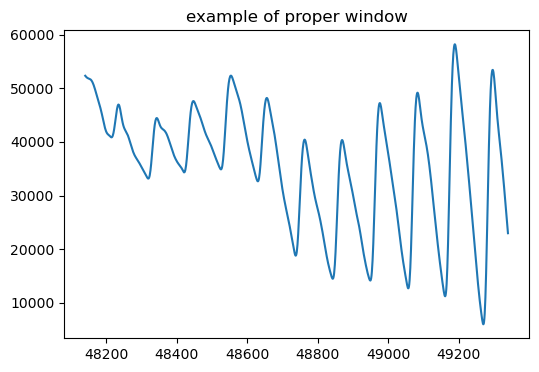

In [56]:
plt.figure(figsize=(6,4))
plt.plot(proper_windows[4]['PLETH'])
plt.title("example of proper window")

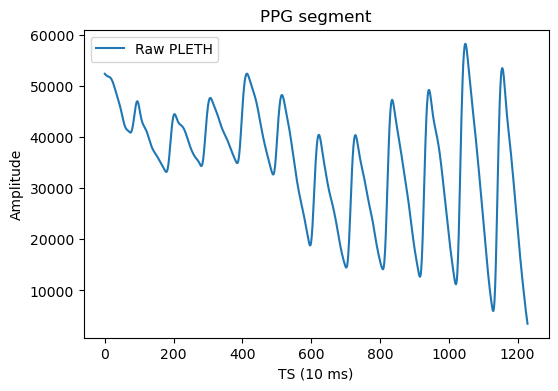

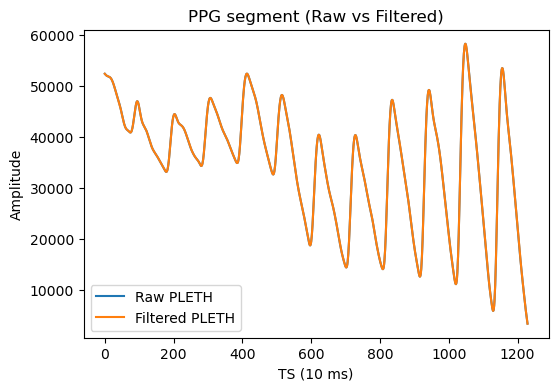

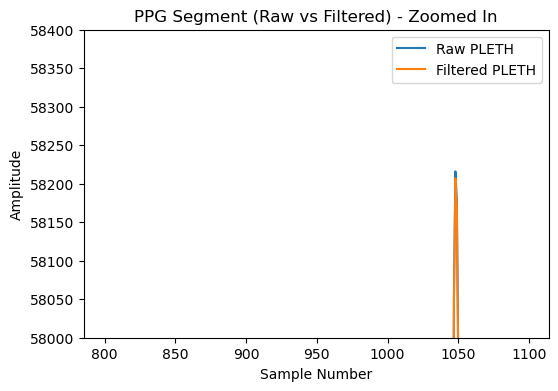

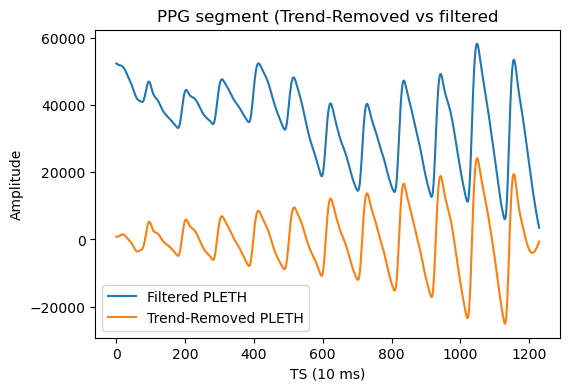

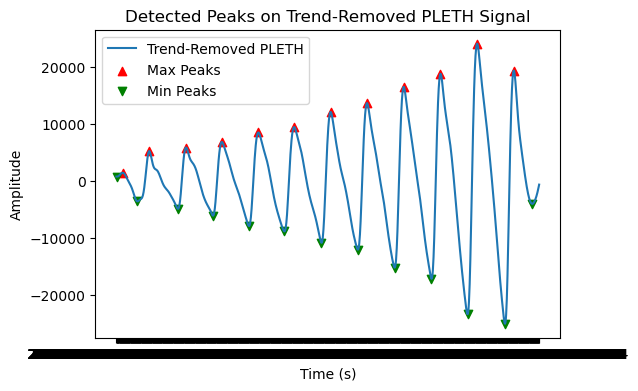

In [62]:
def plot_ppg_processing_steps(wind):
    """
    Plots the steps of PPG signal processing.

    Parameters:
    - wind (DataFrame): The window of PPG data.
    """
    plt.figure(figsize=(6,4))
    # Plot the raw PLETH signal
    plt.plot(range(len(wind['PLETH'])),wind['PLETH'], label='Raw PLETH')
    plt.title('PPG segment')
    plt.xlabel('TS (10 ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    # Apply and plot the filtered PLETH signal
    plt.figure(figsize=(6,4))
    filtered = Segment_Filter(wind['PLETH'], ftype='low')
    plt.plot(range(len(wind['PLETH'])),wind['PLETH'],label='Raw PLETH')
    plt.plot(filtered, label='Filtered PLETH')
    plt.title('PPG segment (Raw vs Filtered)')
    plt.xlabel('TS (10 ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    #zoom in:
    plt.figure(figsize=(6,4))
    plt.plot(range(800, 1100), wind['PLETH'][800:1100], label='Raw PLETH')
    plt.plot(range(800, 1100), filtered[800:1100], label='Filtered PLETH')
    plt.ylim(58000, 58400)
    plt.title('PPG Segment (Raw vs Filtered) - Zoomed In')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


    # Apply and plot the trend-removed PLETH signal
    plt.figure(figsize=(6,4))
    detrended = Segment_Trend_Removel(filtered, ftype='high')
    plt.plot(filtered, label='Filtered PLETH')
    plt.plot(detrended, label='Trend-Removed PLETH')
    plt.title('PPG segment (Trend-Removed vs filtered')
    plt.xlabel('TS (10 ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

def plot_peaks(wind):
    """
    Plots the detected peaks on the detrended PLETH signal.

    Parameters:
    - wind (DataFrame): The window of PPG data.
    """
    plt.figure(figsize=(6, 4))
    plt.plot(wind['DataTime'], wind['HiDeTr_PLETH'], label='Trend-Removed PLETH')
    plt.scatter(wind['DataTime'][wind['is_max_peak']], wind['HiDeTr_PLETH'][wind['is_max_peak']], color='r', marker='^', label='Max Peaks')
    plt.scatter(wind['DataTime'][wind['is_min_peak']], wind['HiDeTr_PLETH'][wind['is_min_peak']], color='g', marker='v', label='Min Peaks')
    plt.title('Detected Peaks on Trend-Removed PLETH Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Select a sample window
sample_window_id = 4  # Adjust the window ID as needed
sample_window = valid_segments_dict[sample_window_id]

# Process the sample window to generate the required columns
WindowFullProcess(sample_window, by_value=False, wind_id=sample_window_id)

# Plot the steps of processing
plot_ppg_processing_steps(sample_window)
plot_peaks(sample_window)

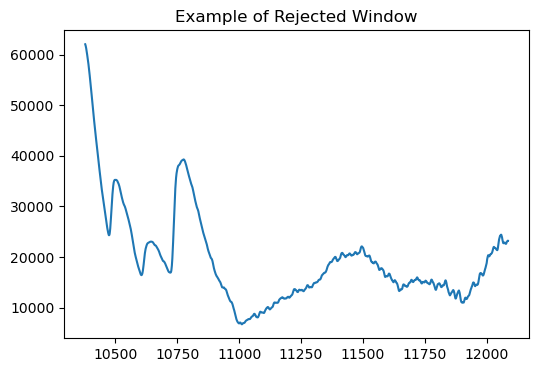

In [64]:
# Create a new figure with a specified size for better visualization
plt.figure(figsize=(6, 4))

# Plot the 'PLETH' values from the first segment in the valid_segments_dict
plt.plot(valid_segments_dict[0]['PLETH'])

# Set the title of the plot to indicate that this is an example of a rejected window
plt.title("Example of Rejected Window")

# Display the plot
plt.show()

In [60]:
# Define the directory path where you want to save the files
directory_path = 'C:/Users/adior/Documents/Digital Medical Tech - degree/Final Mop Project/Train Files/Proper Windows'
#directory_path = 'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/Proper Windows'

file_path = os.path.join(directory_path, 'proper_windows.pkl')

# Create the directory if it does not exist
os.makedirs(directory_path, exist_ok=True)

# Save the dictionary to a pickle file
with open(file_path, 'wb') as f:
    pickle.dump(proper_windows, f)

print(f"Dictionary saved to {file_path}")

Dictionary saved to C:/Users/adior/Documents/Digital Medical Tech - degree/Final Mop Project/Train Files/Proper Windows\proper_windows.pkl
